# Import

In [1]:
from pandas import read_csv, DataFrame, options
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score
from numpy import array, mean, append, unique
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from os import makedirs
from IPython.display import display, Markdown
from statsmodels.formula.api import glm
from math import ceil, floor, sqrt
from pingouin import anova, cronbach_alpha, pairwise_corr, linear_regression, corr
from xgboost import XGBRegressor
from dalex import Explainer
from warnings import filterwarnings
filterwarnings('ignore')
options.display.float_format = '{:.5f}'.format

# Setup
## Load data and setup output dir

In [2]:
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

## Factoring categorical data

In [3]:
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

data["gamer_number"] = data["q9"].map({
    "A frequent video game player": 1,
    "An occasional video game player": 1,
    "A novice video game player": 0,
    "A non-video game player": 0
})

## Composite values

In [4]:
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["comp_average"] = data["comp_mg1"] + data["comp_gmd4"] + data["comp_co5"] + data["comp_co6"]

# Features and Labels

In [23]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    # "total_events", # colinear with the other total_x features
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    # "n_puz_no_basic", # redundant with n_puzzle and p_puz_no_basic
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    # "n_interm", # missing 15+%
    # "n_adv", # missing over 30 values
    # "total_active", # colinear with the other x_active
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    # "diff_event2", # missing 15+%
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    # "gender_number", # external measure
    # "hand_number", # external measure
    # "gamer_number", # missing 15+%
    "enjoyment",
    "comp_average",
    "comp_mg1",
    "comp_gmd4",
    "comp_co5",
    "comp_co6",
    # "sbst, # external measure
    # "sri" # external measure
]

labels = ["sbst", "sri"]
protecteds = ["gender_number", "hand_number"] #, "gamer_number"]
corr_extras = ["so", "mr", "sv"]
everything = features + labels + corr_extras

# Descriptive Stats

## Count missing values

In [6]:
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Non-Missing: {len(data)-num:<4} Count Missing: {num:<4} Percent Missing: {percent:.4}")

Variable: total_breaks         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_submit         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_snapshot       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_view           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_manipulate     Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puzzle             Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: p_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_complete           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_tutorial           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_active         Count Non

## Histogram

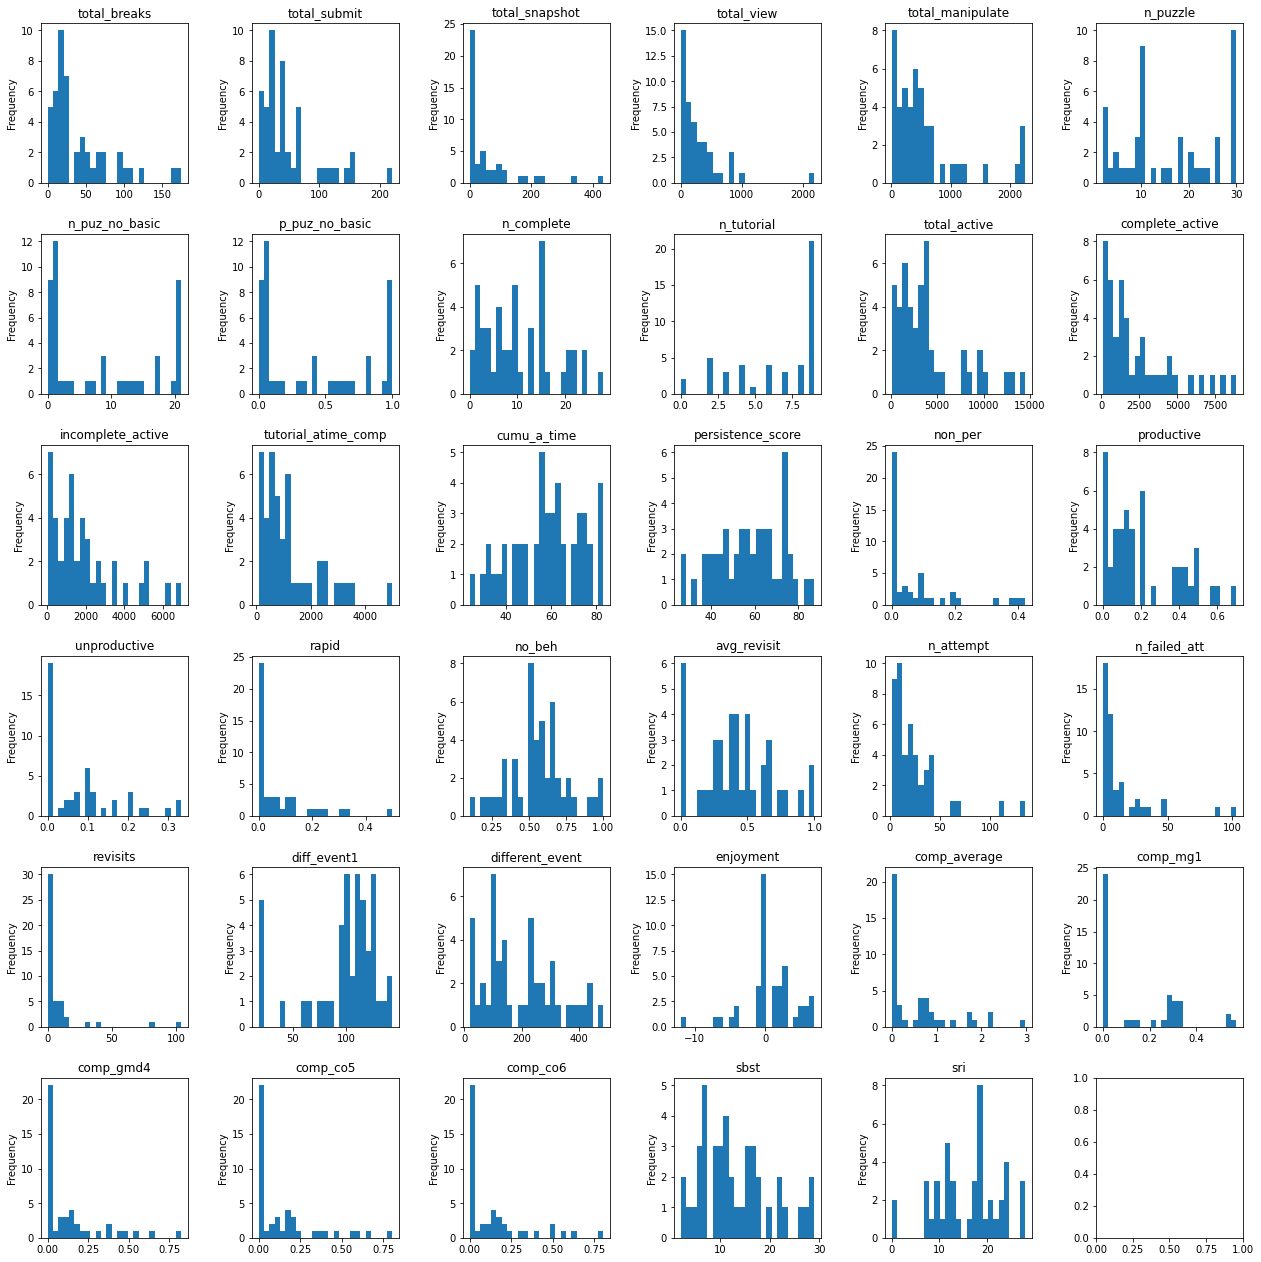

In [7]:
N = ceil(sqrt(len(features + labels)))
fig, axs = subplots(N, N)
fig.set_size_inches(3*N, 3*N)
fig.tight_layout(pad=3.0)
for i, col in enumerate(features + labels):
    data[col].plot(kind="hist", ax=axs[i//N][i%N], title=col, bins=25)

fig.savefig("output/hists.png")

## Percentages in binary categories

In [8]:
# gender
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

# handedness
percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

# handedness
percent_gamer = len(data[data["gamer_number"] == 1]) / len(data) * 100
print(f"Percent of students that are gamers: {percent_gamer:.4}")

Percent of students that are female: 51.06
Percent of students that are left-handed: 19.15
Percent of students that are gamers: 36.17


# Analysis

## Correlation

In [9]:
pw = pairwise_corr(data[features + labels + corr_extras])
pw.to_csv("output/corr.csv", sep="\t")
display(pw)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,total_breaks,total_submit,pearson,two-sided,47,0.81080,"[0.68, 0.89]",0.00000,1.947e+09,1.00000
1,total_breaks,total_snapshot,pearson,two-sided,47,0.43005,"[0.16, 0.64]",0.00255,15.021,0.86848
2,total_breaks,total_view,pearson,two-sided,47,0.32167,"[0.04, 0.56]",0.02746,1.922,0.60744
3,total_breaks,total_manipulate,pearson,two-sided,47,0.75261,"[0.59, 0.85]",0.00000,1.22e+07,1.00000
4,total_breaks,n_puzzle,pearson,two-sided,47,0.63588,"[0.43, 0.78]",0.00000,1.3e+04,0.99892
...,...,...,...,...,...,...,...,...,...,...
698,sri,mr,pearson,two-sided,44,0.89109,"[0.81, 0.94]",0.00000,1.082e+13,1.00000
699,sri,sv,pearson,two-sided,44,0.86592,"[0.77, 0.93]",0.00000,2.203e+11,1.00000
700,so,mr,pearson,two-sided,44,0.61059,"[0.38, 0.77]",0.00001,2199.77,0.99570
701,so,sv,pearson,two-sided,44,0.61764,"[0.39, 0.77]",0.00001,2907.53,0.99654


## Cronbach's Alpha

In [10]:
alpha, _ = cronbach_alpha(data=data[["so", "mr", "sv"]])
print(f"Cronbach's Alpha for SRI facets: {alpha}")

alpha, _ = cronbach_alpha(data=data[[f"sbst{i}" for i in range(1,31)]])
print(f"Cronbach's Alpha for SBST facets: {alpha}")

Cronbach's Alpha for SRI facets: 0.8359066056875625
Cronbach's Alpha for SBST facets: 0.8990425510278549


## ANOVA

In [11]:
# SRI and gender
aov = anova(data=data, dv="sri", between="gender")
print("ANOVA of sri between gender:")
display(aov)
print()

# SBST and gender
aov = anova(data=data, dv="sbst", between="gender")
print("ANOVA of sbst between gender:")
display(aov)
print()

# n_complete and gender
aov = anova(data=data, dv="n_complete", between="gender")
print("ANOVA of n_complete between gender:")
display(aov)
print()


# SRI and hand
aov = anova(data=data, dv="sri", between="hand_number")
print("ANOVA of sri between handedness:")
display(aov)
print()

# SBST and hand
aov = anova(data=data, dv="sbst", between="hand_number")
print("ANOVA of sbst between handedness:")
display(aov)
print()

# n_complete and hand
aov = anova(data=data, dv="n_complete", between="hand_number")
print("ANOVA of n_complete between handedness:")
display(aov)
print()


# SRI and gamer
aov = anova(data=data, dv="sri", between="gamer_number")
print("ANOVA of sri between gamerness:")
display(aov)
print()

# SBST and gamer
aov = anova(data=data, dv="sbst", between="gamer_number")
print("ANOVA of sbst between gamerness:")
display(aov)
print()

# n_complete and gamer
aov = anova(data=data, dv="n_complete", between="gamer_number")
print("ANOVA of n_complete between gamerness:")
display(aov)
print()

ANOVA of sri between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,1.77761,0.18963,0.04061



ANOVA of sbst between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,39,1.83402,0.18345,0.04491



ANOVA of n_complete between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,0.61479,0.43739,0.01443



ANOVA of sri between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,42,0.53698,0.46776,0.01262



ANOVA of sbst between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,39,0.18447,0.66992,0.00471



ANOVA of n_complete between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,42,1.30183,0.26034,0.03006



ANOVA of sri between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,26,0.15639,0.69573,0.00598



ANOVA of sbst between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,27,0.30389,0.58599,0.01113



ANOVA of n_complete between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,27,1.67202,0.20694,0.05832


## Linear Regression

In [24]:
linear_regression(data[features], data["sri"], remove_na=True, as_dataframe=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,47161036.26002,21.45260,2198383.68002,0.00000,0.91540,0.40779,47160981.11436,47161091.40567
1,total_breaks,0.67712,0.36043,1.87863,0.11909,0.91540,0.40779,-0.24940,1.60365
2,total_submit,-0.22965,0.11466,-2.00282,0.10157,0.91540,0.40779,-0.52439,0.06510
3,total_snapshot,-0.06178,0.03947,-1.56527,0.17829,0.91540,0.40779,-0.16324,0.03968
4,total_view,0.05495,0.03383,1.62425,0.16525,0.91540,0.40779,-0.03202,0.14193
5,total_manipulate,0.02605,0.01474,1.76787,0.13732,0.91540,0.40779,-0.01183,0.06393
6,n_puzzle,-9.94878,4.22897,-2.35253,0.06535,0.91540,0.40779,-20.81970,0.92213
7,p_puz_no_basic,53.18118,73.52956,0.72326,0.50193,0.91540,0.40779,-135.83258,242.19494
8,n_complete,6.34675,5.57749,1.13792,0.30672,0.91540,0.40779,-7.99065,20.68416
9,n_tutorial,-9.99797,9.38271,-1.06557,0.33534,0.91540,0.40779,-34.11700,14.12105


In [25]:
lr_features = ["n_puzzle", "p_puz_no_basic", "complete_active", "incomplete_active", "non_per", "productive", "unproductive", "rapid", "no_beh"]
linear_regression(data[lr_features], data["sri"], remove_na=True, as_dataframe=True, relimp=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,-22689795.68706,5.00750,-4531159.44128,0.00000,0.43137,0.25490,-22689805.92855,-22689785.44556,NaN,NaN
1,n_puzzle,-0.48357,0.87724,-0.55124,0.58569,0.43137,0.25490,-2.27773,1.31059,0.02566,6.16155
2,p_puz_no_basic,17.78262,22.26820,0.79857,0.43103,0.43137,0.25490,-27.76095,63.32620,0.03528,8.47026
3,complete_active,0.00009,0.00091,0.10237,0.91916,0.43137,0.25490,-0.00177,0.00196,0.02900,6.96307
4,incomplete_active,-0.00092,0.00093,-0.98818,0.33124,0.43137,0.25490,-0.00283,0.00099,0.03105,7.45667
5,non_per,22689805.52932,9.11422,2489493.90963,0.00000,0.43137,0.25490,22689786.88864,22689824.17000,0.01294,3.10816
6,productive,22689821.71555,8.91533,2545034.80572,0.00000,0.43137,0.25490,22689803.48165,22689839.94944,0.02408,5.78184
7,unproductive,22689798.12474,12.27378,1848640.36189,0.00000,0.43137,0.25490,22689773.02205,22689823.22743,0.08403,20.17750
8,rapid,22689852.40943,10.90052,2081539.07828,0.00000,0.43137,0.25490,22689830.11537,22689874.70349,0.15359,36.88046
9,no_beh,22689809.05642,5.94610,3815914.20950,0.00000,0.43137,0.25490,22689796.89528,22689821.21756,0.02082,5.00048


## Random Forest and XGB

### Helper

In [13]:
# specify the models
label_dict = {
    label: data[data[label] > 0][everything].dropna()
    for label in labels
}

model_dict = {
    "xgb": XGBRegressor(tree_method="hist", random_state=42),
    "rf": RandomForestRegressor(n_estimators=1000, random_state=42)
}

param_dict = { # TODO
    "xgb": {},
    "rf": {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
}

# Helper to run all the steps for a given dependent variable and regressor
def run_regressor(m, label, features, protecteds):
    
    # Heading
    display(Markdown(f"---\n\n# {m} {label}"))
    
    # Conventional Shorthand
    model = model_dict[m]
    subdata = label_dict[label]
    X = subdata[features]
    y = subdata[label]
    
    # Hyperparameter tuning
    parameters = param_dict[m]
    search = RandomizedSearchCV(model, parameters, scoring="r2", n_iter=200, cv=2, verbose=2, random_state=42, n_jobs=-1)
    search.fit(X, y)
    display(Markdown(f"**Hyperparameters:**"))
    display(DataFrame(search.best_params_, index=[0]))
    model.set_params(**search.best_params_)
    
    # Fit model
    yhat = cross_val_predict(model, X, y, cv=2)
    model.fit(X, y)
    
    # Check goodness
    errors = abs(yhat - y)
    mae = round(mean(errors), 2)
    display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
    display(Markdown(f"**Pearson:**"))
    display(corr(yhat, y))
    display(Markdown(f"**R^2 Score:**"))
    display(r2_score(y, yhat))
    
    # Explain features
    explain = Explainer(model, X, y, verbose=False)
    explain.model_parts().plot()
    
    # Check fairness
    for col in protecteds:
        display(Markdown(f"## {col}"))
        for c in unique(X[col].values):
            display(Markdown(f"### where {col}=={c}"))
            rows = X[col] == c
            try:
                mae = round(mean(errors[rows]), 2)
                display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
                display(Markdown(f"**Pearson:**"))
                display(corr(yhat[rows], y[rows]))
                display(Markdown(f"**R^2 Score:**"))
                display(r2_score(y[rows], yhat[rows]))
            except Exception as e:
                print(f"(Unable to run a regression on {col}, there are probably not enough values in one of the test subgroups.")

### Run

In [14]:
run_regressor("rf", "sri", features, protecteds)

---

# rf sri

Fitting 2 folds for each of 200 candidates, totalling 400 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   2.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimato

KeyboardInterrupt: 

In [ ]:
run_regressor("rf", "sbst", features, protecteds)

In [ ]:
# run_regressor("xgb", "sri", features, protecteds)

In [ ]:
# run_regressor("xgb", "sbst", features, protecteds)